In [1]:
%load_ext autoreload
%autoreload 2

# Example 3: using the outputs of GSN to denoise data ("GSNdenoise")

## Overview
This notebook demonstrates the application of GSNdenoise on fMRI data. 
It includes steps for data preparation, denoising using GSN, and visualization of results.

Users encountering bugs, unexpected outputs, or other issues regarding GSN shouldn't hesitate to raise an issue on GitHub: https://github.com/cvnlab/GSN/issues

The example data has dimensionality 100 voxels x 200 conditions x 3 trials. The data are from an fMRI experiment measuring responses to auditory sentences. The values reflect fMRI response amplitudes in percent BOLD signal change units. The voxels are taken from a brain region in the left hemisphere. 

---

In [3]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
from scipy.spatial.distance import pdist
import os
from os.path import exists
import sys

# Add the GSN project directory to the system path
sys.path.append(f'{os.getcwd()}/../')

# Import GSN-related modules
from gsn.gsn_denoise import gsn_denoise
from gsn.perform_gsn import perform_gsn


In [4]:
# Define paths for home, data, and output directories
homedir = os.path.dirname(os.getcwd())  # More reliable way to get parent directory
datadir = os.path.join(homedir, 'examples', 'data')
outputdir = os.path.join(homedir, 'examples', 'example3outputs')  # Changed to example3 for this notebook

# Create directories if they do not exist
try:
    os.makedirs(datadir, exist_ok=True)
    os.makedirs(outputdir, exist_ok=True)
except PermissionError:
    print("Error: Don't have permission to create directories. Please check your permissions.")
    raise
except Exception as e:
    print(f"Error creating directories: {str(e)}")
    raise

# Display the configured directories with better formatting
print("Directory Configuration:")
print(f"├── Data Directory:\n│   └── {datadir}")
print(f"└── Output Directory:\n    └── {outputdir}")

# Verify directories are writable
if not os.access(datadir, os.W_OK):
    print("\nWarning: Data directory is not writable!")
if not os.access(outputdir, os.W_OK):
    print("\nWarning: Output directory is not writable!")

Directory Configuration:
├── Data Directory:
│   └── /Users/jacobprince/KonkLab Dropbox/Jacob Prince/Research-Prince/GSNdenoise/GSN/examples/data
└── Output Directory:
    └── /Users/jacobprince/KonkLab Dropbox/Jacob Prince/Research-Prince/GSNdenoise/GSN/examples/example3outputs


## Download dataset

In [5]:
# Define the file name for the dataset
datafn = os.path.join(datadir, 'exampledata.mat')

# Download and load the example dataset
def download_example_data(url, filename):
    """
    Download example dataset if it doesn't exist locally.
    
    Args:
        url (str): URL to download the data from
        filename (str): Local path to save the data
    """
    if not exists(filename):
        print(f'Downloading example dataset from OSF...\nSaving to: {filename}')
        try:
            urllib.request.urlretrieve(url, filename)
            print('Download completed successfully.')
        except urllib.error.URLError as e:
            print(f'Error downloading data: {e}')
            raise
        except Exception as e:
            print(f'Unexpected error: {e}')
            raise
    else:
        print(f'Using existing dataset from: {filename}')

# URL for the example fMRI dataset
dataurl = 'https://osf.io/download/utfpq/'

# Download data if needed
download_example_data(dataurl, datafn)

# Load the dataset
try:
    X = sio.loadmat(datafn)
    
    # Split data into training (even indices) and testing (odd indices)
    train_data = X['data'].copy()[:, ::2]
    test_data = X['data'].copy()[:, 1::2]
    
    # Extract and display dataset dimensions
    nvox, ncond, ntrial = train_data.shape
    print('\nDataset Properties:')
    print(f'├── Dimensions:')
    print(f'│   ├── Voxels: {nvox}')
    print(f'│   ├── Conditions: {ncond}')
    print(f'│   └── Trials: {ntrial}')
    print(f'├── Training Data Range: [{train_data.min():.3f}, {train_data.max():.3f}]')
    print(f'└── Test Data Range: [{test_data.min():.3f}, {test_data.max():.3f}]')
    
except Exception as e:
    print(f'Error loading or processing the dataset: {e}')
    raise

Using existing dataset from: /Users/jacobprince/KonkLab Dropbox/Jacob Prince/Research-Prince/GSNdenoise/GSN/examples/data/exampledata.mat

Dataset Properties:
├── Dimensions:
│   ├── Voxels: 100
│   ├── Conditions: 100
│   └── Trials: 3
├── Training Data Range: [-6.642, 9.414]
└── Test Data Range: [-4.695, 9.999]


In [6]:
# Split the loaded data into training (even indices) and testing (odd indices)
try:
    # Ensure data exists and has correct format
    if 'data' not in X:
        raise KeyError("Dataset does not contain 'data' field")
    
    # Create training and test sets
    train_data = X['data'].copy()[:, ::2]  # Even indices
    test_data = X['data'].copy()[:, 1::2]  # Odd indices
    
    # Extract dimensions
    nvox, ncond, ntrial = train_data.shape
    
    # Validate dimensions
    if ntrial < 2:
        raise ValueError("Data must have at least 2 trials for denoising")
    
    # Print detailed dataset information
    print("\nDataset Split Information:")
    print("├── Original Data:")
    print(f"│   └── Shape: {X['data'].shape} (voxels × conditions × trials)")
    print("├── Training Data (even conditions):")
    print(f"│   ├── Shape: {train_data.shape}")
    print(f"│   └── Range: [{train_data.min():.3f}, {train_data.max():.3f}]")
    print("└── Test Data (odd conditions):")
    print(f"    ├── Shape: {test_data.shape}")
    print(f"    └── Range: [{test_data.min():.3f}, {test_data.max():.3f}]")

except Exception as e:
    print(f"Error processing dataset: {e}")
    raise


Dataset Split Information:
├── Original Data:
│   └── Shape: (100, 200, 3) (voxels × conditions × trials)
├── Training Data (even conditions):
│   ├── Shape: (100, 100, 3)
│   └── Range: [-6.642, 9.414]
└── Test Data (odd conditions):
    ├── Shape: (100, 100, 3)
    └── Range: [-4.695, 9.999]


## Perform GSN

In [7]:
# Configure GSN options
opt = {
    'wantshrinkage': True,    # Enable covariance shrinkage for better estimation
    'wantverbose': True       # Print status updates during computation
}

print("Performing GSN analysis on training data...")
print("├── Options:")
print(f"│   ├── Shrinkage: {opt['wantshrinkage']}")
print(f"│   └── Verbose: {opt['wantverbose']}")

# Perform GSN analysis
try:
    results_gsn = perform_gsn(train_data.copy(), opt)
    
    # Print summary of results
    print("└── Results:")
    print(f"    ├── Signal covariance matrix shape: {results_gsn['cSb'].shape}")
    print(f"    ├── Noise covariance matrix shape: {results_gsn['cNb'].shape}")
    print(f"    ├── Shrinkage level (noise): {results_gsn['shrinklevelN']:.3f}")
    print(f"    ├── Shrinkage level (data): {results_gsn['shrinklevelD']:.3f}")
    print(f"    ├── Number of iterations: {results_gsn['numiters']}")
    print(f"    └── Noise ceiling SNR range: [{results_gsn['ncsnr'].min():.3f}, {results_gsn['ncsnr'].max():.3f}]")

except Exception as e:
    print(f"Error during GSN analysis: {e}")
    raise

Performing GSN analysis on training data...
├── Options:
│   ├── Shrinkage: True
│   └── Verbose: True
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.
└── Results:
    ├── Signal covariance matrix shape: (100, 100)
    ├── Noise covariance matrix shape: (100, 100)
    ├── Shrinkage level (noise): 0.820
    ├── Shrinkage level (data): 0.560
    ├── Number of iterations: 1
    └── Noise ceiling SNR range: [0.000, 0.629]


/Users/jacobprince/mambaforge/envs/gsndenoise/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jacobprince/mambaforge/envs/gsndenoise/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


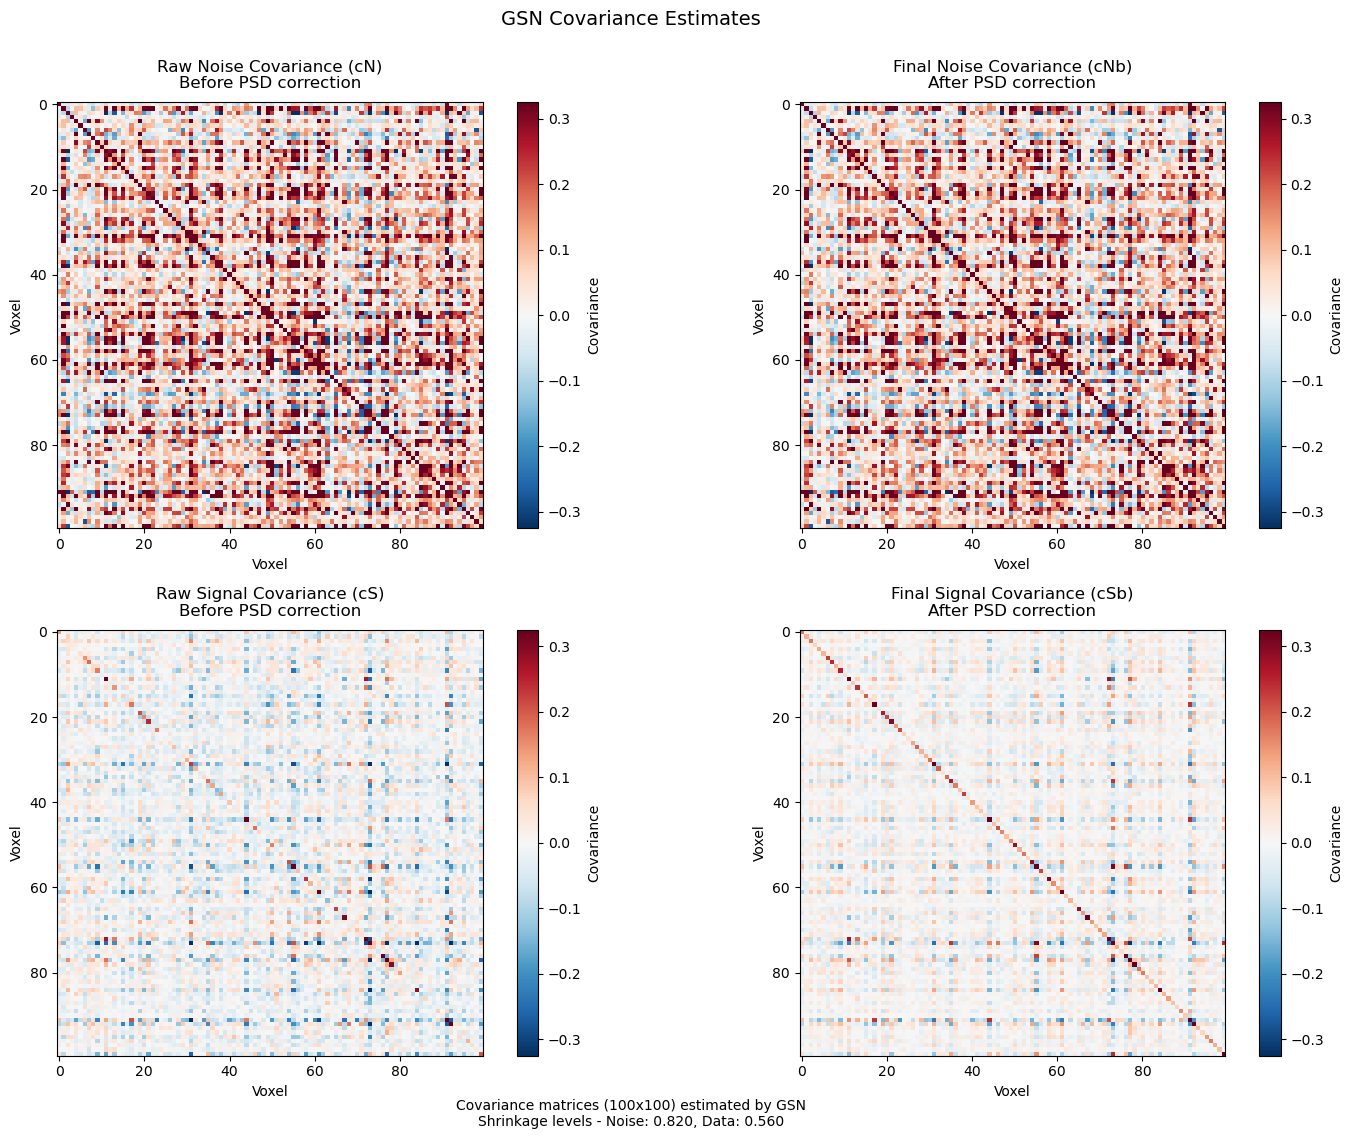


Matrix Properties:
├── Positive Semi-Definite Check:
│   ├── cN: ✓ (min eigenvalue: 1.15e-01)
│   ├── cNb: ✓ (min eigenvalue: 1.15e-01)
│   ├── cS: ✗ (min eigenvalue: -2.51e+00)
│   ├── cSb: ✓ (min eigenvalue: 1.00e-10)
└── Condition Numbers:
    ├── cN: 1.60e+02
    ├── cNb: 1.57e+02
    ├── cS: 1.04e+03
    ├── cSb: 3.73e+10


In [8]:
# Create a function for better subplot formatting
def format_covariance_plot(ax, matrix, title, vmin, vmax):
    """Helper function to format covariance matrix plots consistently."""
    im = ax.imshow(matrix, vmin=vmin, vmax=vmax, 
                   aspect='equal', interpolation='nearest', cmap='RdBu_r')
    ax.set_title(title, pad=10)
    ax.set_xlabel('Voxel')
    ax.set_ylabel('Voxel')
    return im

# Set up the visualization parameters
fig = plt.figure(figsize=(15, 12))
fig.suptitle('GSN Covariance Estimates', fontsize=14, y=0.95)

# Determine color range based on data
all_covs = np.concatenate([results_gsn['cN'].flatten(), 
                          results_gsn['cNb'].flatten(),
                          results_gsn['cS'].flatten(), 
                          results_gsn['cSb'].flatten()])
vmax = np.percentile(np.abs(all_covs), 95)  # Use 95th percentile for better contrast
vrange = [-vmax, vmax]

# Create subplots
axes = []
titles = [
    ('Raw Noise Covariance (cN)\nBefore PSD correction', results_gsn['cN']),
    ('Final Noise Covariance (cNb)\nAfter PSD correction', results_gsn['cNb']),
    ('Raw Signal Covariance (cS)\nBefore PSD correction', results_gsn['cS']),
    ('Final Signal Covariance (cSb)\nAfter PSD correction', results_gsn['cSb'])
]

for idx, (title, matrix) in enumerate(titles, 1):
    ax = plt.subplot(2, 2, idx)
    im = format_covariance_plot(ax, matrix, title, vrange[0], vrange[1])
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Covariance')
    

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Add overall caption
caption = (
    f"Covariance matrices ({nvox}x{nvox}) estimated by GSN\n"
    f"Shrinkage levels - Noise: {results_gsn['shrinklevelN']:.3f}, Data: {results_gsn['shrinklevelD']:.3f}"
)
plt.figtext(0.5, 0.02, caption, ha='center', fontsize=10)

plt.show()

# Print additional information about the matrices
print("\nMatrix Properties:")
print("├── Positive Semi-Definite Check:")
for name, mat in [('cN', results_gsn['cN']), ('cNb', results_gsn['cNb']), 
                 ('cS', results_gsn['cS']), ('cSb', results_gsn['cSb'])]:
    eigvals = np.linalg.eigvalsh(mat)
    is_psd = np.all(eigvals >= -1e-10)  # Allow for numerical precision issues
    print(f"│   ├── {name}: {'✓' if is_psd else '✗'} (min eigenvalue: {eigvals.min():.2e})")
print("└── Condition Numbers:")
for name, mat in [('cN', results_gsn['cN']), ('cNb', results_gsn['cNb']), 
                 ('cS', results_gsn['cS']), ('cSb', results_gsn['cSb'])]:
    cond = np.linalg.cond(mat)
    print(f"    ├── {name}: {cond:.2e}")

GSN Analysis Results Summary:
├── Distribution Means:
│   ├── Noise (mnN) range: [0.000, 0.000]
│   └── Signal (mnS) range: [-0.750, 3.383]
│
├── Covariance Estimates:
│   ├── Noise Covariance:
│   │   ├── Raw (cN): (100, 100), condition number: 1.6e+02
│   │   └── Final (cNb): (100, 100), condition number: 1.6e+02
│   │
│   └── Signal Covariance:
│       ├── Raw (cS): (100, 100), condition number: 1.0e+03
│       └── Final (cSb): (100, 100), condition number: 3.7e+10
│
├── Shrinkage Levels:
│   ├── Noise (shrinklevelN): 0.820
│   └── Data (shrinklevelD): 0.560
│
└── Noise Ceiling SNR:
    ├── Range: [0.000, 0.629]
    ├── Mean: 0.245
    └── Median: 0.262


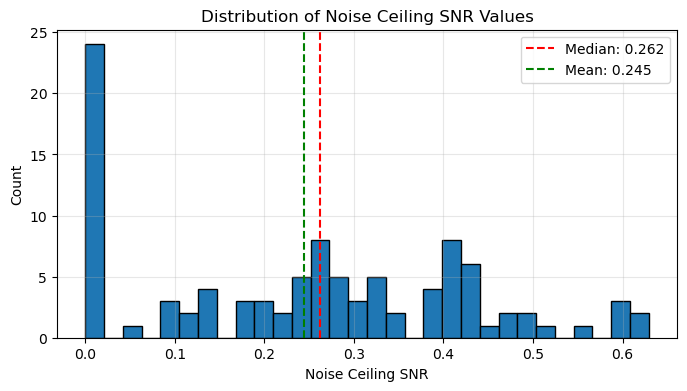

In [9]:
# Print comprehensive summary of GSN results
print("GSN Analysis Results Summary:")
print("├── Distribution Means:")
print(f"│   ├── Noise (mnN) range: [{results_gsn['mnN'].min():.3f}, {results_gsn['mnN'].max():.3f}]")
print(f"│   └── Signal (mnS) range: [{results_gsn['mnS'].min():.3f}, {results_gsn['mnS'].max():.3f}]")
print("│")
print("├── Covariance Estimates:")
print("│   ├── Noise Covariance:")
print(f"│   │   ├── Raw (cN): {results_gsn['cN'].shape}, condition number: {np.linalg.cond(results_gsn['cN']):.1e}")
print(f"│   │   └── Final (cNb): {results_gsn['cNb'].shape}, condition number: {np.linalg.cond(results_gsn['cNb']):.1e}")
print("│   │")
print("│   └── Signal Covariance:")
print(f"│       ├── Raw (cS): {results_gsn['cS'].shape}, condition number: {np.linalg.cond(results_gsn['cS']):.1e}")
print(f"│       └── Final (cSb): {results_gsn['cSb'].shape}, condition number: {np.linalg.cond(results_gsn['cSb']):.1e}")
print("│")
print("├── Shrinkage Levels:")
print(f"│   ├── Noise (shrinklevelN): {results_gsn['shrinklevelN']:.3f}")
print(f"│   └── Data (shrinklevelD): {results_gsn['shrinklevelD']:.3f}")
print("│")
print("└── Noise Ceiling SNR:")
print(f"    ├── Range: [{results_gsn['ncsnr'].min():.3f}, {results_gsn['ncsnr'].max():.3f}]")
print(f"    ├── Mean: {results_gsn['ncsnr'].mean():.3f}")
print(f"    └── Median: {np.median(results_gsn['ncsnr']):.3f}")

# Optional: Create histogram of noise ceiling SNR values
plt.figure(figsize=(8, 4))
plt.hist(results_gsn['ncsnr'], bins=30, edgecolor='black')
plt.title('Distribution of Noise Ceiling SNR Values')
plt.xlabel('Noise Ceiling SNR')
plt.ylabel('Count')
plt.axvline(np.median(results_gsn['ncsnr']), color='r', linestyle='--', 
            label=f'Median: {np.median(results_gsn["ncsnr"]):.3f}')
plt.axvline(results_gsn['ncsnr'].mean(), color='g', linestyle='--', 
            label=f'Mean: {results_gsn["ncsnr"].mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Use estimated signal covariance to compute a basis for denoising

Computing eigendecomposition of signal covariance matrix...
Components needed for 80% variance: 27
Components needed for 90% variance: 38
Components needed for 95% variance: 46


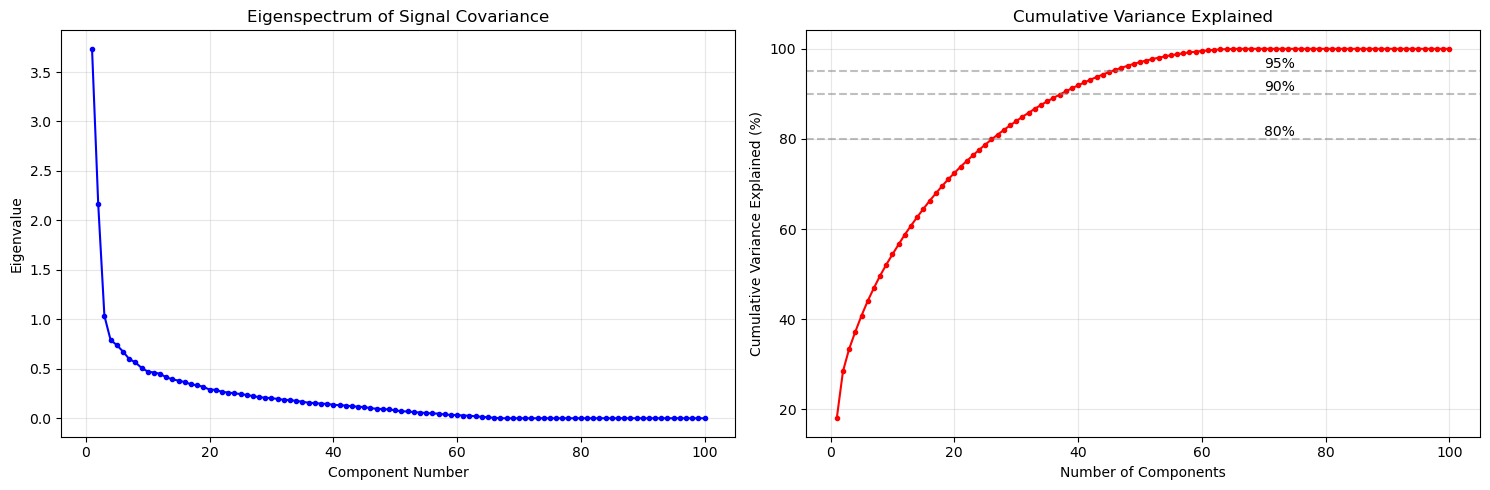


Eigendecomposition Summary:
├── Total components: 100
├── Eigenvalue range: [1.000e-10, 3.735e+00]
├── Condition number: 3.735e+10
└── Variance explained thresholds:
    ├── 50%: 9 components
    ├── 80%: 27 components
    ├── 90%: 38 components
    ├── 95%: 46 components
    ├── 99%: 57 components


In [10]:
# Perform eigendecomposition of the signal covariance matrix (cSb)
print("Computing eigendecomposition of signal covariance matrix...")

# Compute eigendecomposition
S, V = np.linalg.eigh(results_gsn['cSb'])
# Sort eigenvalues and eigenvectors in descending order
idx = np.flip(np.argsort(S))
S = S[idx]
V = V[:, idx]

# Create visualization of eigenspectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot eigenspectrum
ax1.plot(np.arange(1, len(S) + 1), S, 'b.-')
ax1.set_xlabel('Component Number')
ax1.set_ylabel('Eigenvalue')
ax1.set_title('Eigenspectrum of Signal Covariance')
ax1.grid(True, alpha=0.3)

# Calculate and plot cumulative variance explained
explained_var = np.cumsum(S) / np.sum(S) * 100
ax2.plot(np.arange(1, len(S) + 1), explained_var, 'r.-')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained')
ax2.grid(True, alpha=0.3)

# Add horizontal lines at 80%, 90%, 95% variance explained
for pct in [80, 90, 95]:
    components_needed = np.where(explained_var >= pct)[0][0] + 1
    ax2.axhline(y=pct, color='gray', linestyle='--', alpha=0.5)
    ax2.text(len(S) * 0.7, pct, f'{pct}%', verticalalignment='bottom')
    print(f"Components needed for {pct}% variance: {components_needed}")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nEigendecomposition Summary:")
print(f"├── Total components: {len(S)}")
print(f"├── Eigenvalue range: [{S.min():.3e}, {S.max():.3e}]")
print(f"├── Condition number: {S.max() / S.min():.3e}")
print("└── Variance explained thresholds:")
for pct in [50, 80, 90, 95, 99]:
    n_components = np.where(explained_var >= pct)[0][0] + 1
    print(f"    ├── {pct}%: {n_components} components")

# Check for negative eigenvalues (shouldn't occur for a valid covariance matrix)
if np.any(S < -1e-10):  # Allow for numerical precision issues
    print("\nWarning: Negative eigenvalues detected!")
    print(f"Number of negative eigenvalues: {np.sum(S < -1e-10)}")
    print(f"Minimum eigenvalue: {S.min():.3e}")

## Compute the denoising matrix

In [11]:
# Configure options for GSN denoising
opt = {
    'cv_mode': 0,                    # Use leave-one-out cross-validation
    'cv_threshold_per': 'unit', # Use same threshold for all voxels
    'cv_thresholds': np.arange(1, nvox + 1),  # Test all possible dimensionalities
    'denoisingtype': 1              # 0 for trial-averaged denoising
}

print("Performing GSN denoising with cross-validation...")
print("├── Options:")
print(f"│   ├── Cross-validation mode: {opt['cv_mode']}")
print(f"│   ├── Threshold type: {opt['cv_threshold_per']}")
print(f"│   ├── Number of thresholds tested: {len(opt['cv_thresholds'])}")
print(f"│   └── Denoising type: {'Trial-averaged' if opt['denoisingtype'] == 0 else 'Single-trial'}")

# Call GSN denoising and get results dictionary
results = gsn_denoise(
    train_data.copy(), 
    V=V.copy(),  # Use signal covariance eigenvectors as basis
    opt=opt
)

Performing GSN denoising with cross-validation...
├── Options:
│   ├── Cross-validation mode: 0
│   ├── Threshold type: unit
│   ├── Number of thresholds tested: 100
│   └── Denoising type: Single-trial


## Apply the denoising matrix to held-out data

Applying denoiser to held-out test data...
├── Max decomposition error: 4.44e-16
└── Performance metrics on held-out data:
    ├── MSE improvement: 0.341
    └── Noise fraction: 0.625


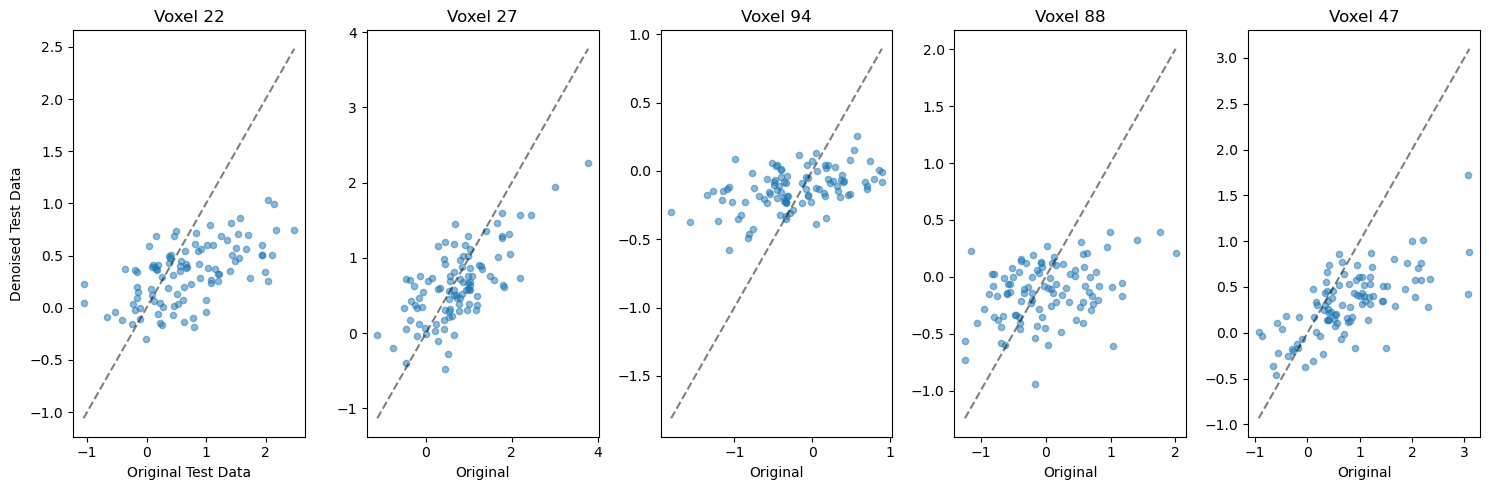

In [12]:
# Apply the denoiser to held-out test data
print("Applying denoiser to held-out test data...")

# Apply denoising to test data
test_data_denoised = np.zeros_like(test_data)
if opt['denoisingtype'] == 0:
    # Trial-averaged denoising
    test_avg = np.mean(test_data, axis=2)
    test_denoised_avg = (test_avg.T @ results['denoiser']).T
    for tr in range(test_data.shape[2]):
        test_data_denoised[:, :, tr] = test_denoised_avg
else:
    # Single-trial denoising
    for tr in range(test_data.shape[2]):
        test_data_denoised[:, :, tr] = (test_data[:, :, tr].T @ results['denoiser']).T

# Calculate noise as the difference between original and denoised data
test_avg = np.mean(test_data, axis=2)
test_denoised_avg = np.mean(test_data_denoised, axis=2)
noise = test_avg - test_denoised_avg

# Verify data decomposition
decomp_error = np.max(np.abs(test_avg - (test_denoised_avg + noise)))
print(f"├── Max decomposition error: {decomp_error:.2e}")

# Calculate performance metrics
mse_improvement = np.mean((test_avg - test_denoised_avg) ** 2) / np.mean(test_avg ** 2)
print("└── Performance metrics on held-out data:")
print(f"    ├── MSE improvement: {mse_improvement:.3f}")
print(f"    └── Noise fraction: {np.mean(np.abs(noise)) / np.mean(np.abs(test_avg)):.3f}")

# Visualize results for a random subset of voxels
n_example_voxels = 5
example_voxels = np.random.choice(nvox, n_example_voxels, replace=False)

plt.figure(figsize=(15, 5))
for i, vox in enumerate(example_voxels, 1):
    plt.subplot(1, n_example_voxels, i)
    plt.scatter(test_avg[vox, :], test_denoised_avg[vox, :], alpha=0.5, s=20)
    
    # Add unity line
    lims = [
        min(test_avg[vox, :].min(), test_denoised_avg[vox, :].min()),
        max(test_avg[vox, :].max(), test_denoised_avg[vox, :].max())
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5)
    
    plt.title(f'Voxel {vox}')
    if i == 1:
        plt.xlabel('Original Test Data')
        plt.ylabel('Denoised Test Data')
    else:
        plt.xlabel('Original')

plt.tight_layout()
plt.show()

## Diagnostic plots

In [14]:
def compute_noise_ceiling(data_in):
    """
    Compute the noise ceiling signal-to-noise ratio (SNR) and percentage noise ceiling for each unit.
    
    The function calculates noise ceiling metrics for a given dataset, where the data is typically 
    organized as (units/voxels, conditions, trials). The noise ceiling represents the upper limit of 
    performance that can be explained by the data, taking into account the signal and noise variances.

    Parameters:
    ----------
    data_in : np.ndarray
        A 3D array of shape (units/voxels, conditions, trials), representing the data for which to compute 
        the noise ceiling. Each unit requires more than 1 trial for each condition.

    Returns:
    -------
    noiseceiling : np.ndarray
        The noise ceiling for each unit, expressed as a percentage.
    ncsnr : np.ndarray
        The noise ceiling signal-to-noise ratio (SNR) for each unit.
    
    Notes:
    ------
    - The noise variance is computed as the average variance across trials for each unit.
    - The data variance is computed as the variance of the mean across trials for each unit.
    - The signal variance is estimated by subtracting the noise variance from the data variance.
    - The noise ceiling percentage is based on the SNR of the signal relative to the noise.
    """

    # noisevar: mean variance across trials for each unit
    noisevar = np.mean(np.std(data_in, axis=2, ddof=1) ** 2, axis=1)

    # datavar: variance of the trial means across conditions for each unit
    datavar = np.std(np.mean(data_in, axis=2), axis=1, ddof=1) ** 2

    # signalvar: signal variance, obtained by subtracting noise variance from data variance
    signalvar = np.maximum(datavar - noisevar / data_in.shape[2], 0)  # Ensure non-negative variance

    # ncsnr: signal-to-noise ratio (SNR) for each unit
    ncsnr = np.sqrt(signalvar) / np.sqrt(noisevar)

    # noiseceiling: percentage noise ceiling based on SNR
    noiseceiling = 100 * (ncsnr ** 2 / (ncsnr ** 2 + 1 / data_in.shape[2]))

    return noiseceiling, ncsnr, signalvar, noisevar

/var/folders/b5/z8z92dmn6lnfsg0r78yj48pr0000gn/T/ipykernel_42136/1342166292.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncsnrs.append(float(ncsnr))  # Convert to float
/var/folders/b5/z8z92dmn6lnfsg0r78yj48pr0000gn/T/ipykernel_42136/1342166292.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigvars.append(float(sigvar))  # Convert to float
/var/folders/b5/z8z92dmn6lnfsg0r78yj48pr0000gn/T/ipykernel_42136/1342166292.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated

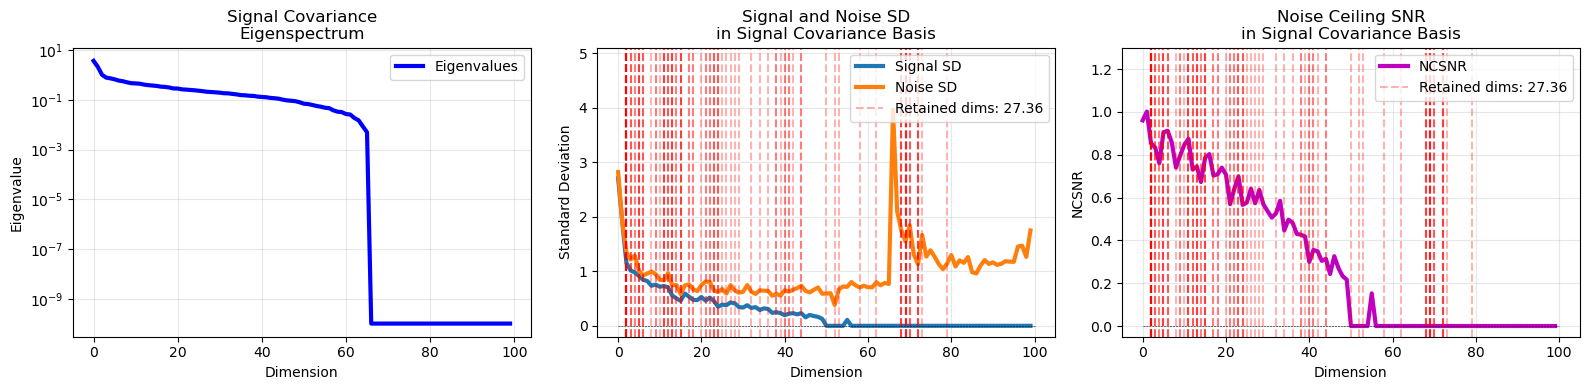


NCNSR Analysis Summary:
├── Signal SD range: [0.000, 2.709]
├── Noise SD range: [0.382, 3.964]
├── NCSNR range: [0.000, 1.002]


In [15]:
def plot_basis_dim_ncsnrs(data, eigvecs, basis_name, best_threshold, S, subplots=(131, 132, 133)):
    """
    Plot signal and noise standard deviations (SD) and noise ceiling SNR (ncsnr)
    for data projected into a given basis.
    """
    # Initialize lists to store results for each basis dimension
    ncsnrs = []     # Noise ceiling signal-to-noise ratios
    sigvars = []    # Signal variances
    noisevars = []  # Noise variances

    # Compute eigenvalues of S for the eigenspectrum plot
    eigenvals = np.sort(S)[::-1]  # Sort in descending order

    # Compute ncsnr, signal variance, and noise variance for each basis dimension
    for i in range(eigvecs.shape[1]):
        this_eigv = eigvecs[:, i]  # Select the i-th eigenvector
        proj_data = np.dot(data, this_eigv)  # Project data into this eigenvector's subspace

        # Compute noise ceiling metrics for the projected data
        _, ncsnr, sigvar, noisevar = compute_noise_ceiling(proj_data[np.newaxis, ...])
        ncsnrs.append(float(ncsnr))  # Convert to float
        sigvars.append(float(sigvar))  # Convert to float
        noisevars.append(float(noisevar))  # Convert to float

    # Create the visualization
    plt.figure(figsize=(16, 4))
    
    # Plot 1: Eigenspectrum
    plt.subplot(131)
    plt.plot(eigenvals, linewidth=3, color='b', label='Eigenvalues')
    plt.title('Signal Covariance\nEigenspectrum')
    plt.xlabel('Dimension')
    plt.ylabel('Eigenvalue')
    plt.yscale('log')  # Use log scale for eigenspectrum
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Signal and noise standard deviations
    plt.subplot(132)
    plt.plot(np.sqrt(sigvars), linewidth=3, label='Signal SD')
    plt.plot(np.sqrt(noisevars), linewidth=3, label='Noise SD')
    plt.xlabel('Dimension')
    plt.ylabel('Standard Deviation')
    plt.title(f'Signal and Noise SD\nin {basis_name} Basis')
    plt.plot([0, len(sigvars)], [0, 0], 'k--', linewidth=0.4)
    
    # Handle different types of best_threshold for SD plot
    if isinstance(best_threshold, (list, np.ndarray)):
        if np.all(np.diff(best_threshold) == 1) and best_threshold[0] == 0:
            plt.axvline(len(best_threshold), color='r', linestyle='--', 
                       label=f'Cutoff: {len(best_threshold)} dims')
        else:
            for idx in best_threshold:
                plt.axvline(idx + 1, color='r', linestyle='--', alpha=0.3)
            plt.axvline(idx + 1, color='r', linestyle='--', alpha=0.3,
                       label=f'Retained dims: {np.mean(best_threshold)}')
    elif isinstance(best_threshold, (int, np.integer)):  # Handle numpy integer types
        plt.axvline(best_threshold, color='r', linestyle='--',
                   label=f'Cutoff: {best_threshold} dims')
    plt.ylim([-0.2, 5.1])
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: NCSNR
    plt.subplot(133)
    plt.plot(ncsnrs, linewidth=3, color='m', label='NCSNR')
    plt.title(f'Noise Ceiling SNR\nin {basis_name} Basis')
    plt.xlabel('Dimension')
    plt.ylabel('NCSNR')
    plt.plot([0, len(sigvars)], [0, 0], 'k--', linewidth=0.4)
    
    # Handle different types of best_threshold for NCSNR plot
    if isinstance(best_threshold, (list, np.ndarray)):
        if np.all(np.diff(best_threshold) == 1) and best_threshold[0] == 0:
            plt.axvline(len(best_threshold), color='r', linestyle='--', 
                       label=f'Cutoff: {len(best_threshold)} dims')
        else:
            for idx in best_threshold:
                plt.axvline(idx + 1, color='r', linestyle='--', alpha=0.3)
            plt.axvline(idx + 1, color='r', linestyle='--', alpha=0.3,
                       label=f'Retained dims: {np.mean(best_threshold)}')
    elif isinstance(best_threshold, (int, np.integer)):  # Handle numpy integer types
        plt.axvline(best_threshold, color='r', linestyle='--',
                   label=f'Cutoff: {best_threshold} dims')
    plt.ylim([-0.05, 1.3])
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nNCNSR Analysis Summary:")
    print(f"├── Signal SD range: [{min(np.sqrt(sigvars)):.3f}, {max(np.sqrt(sigvars)):.3f}]")
    print(f"├── Noise SD range: [{min(np.sqrt(noisevars)):.3f}, {max(np.sqrt(noisevars)):.3f}]")
    print(f"├── NCSNR range: [{min(ncsnrs):.3f}, {max(ncsnrs):.3f}]")

# Call the function with our data
plot_basis_dim_ncsnrs(
    train_data.copy().transpose(1, 2, 0),  # Reshape to match function expectations
    results['fullbasis'],                  # Eigenvectors from results
    'Signal Covariance',                   # Basis name
    results['best_threshold'],               # Selected threshold from results
    S                                      # Signal covariance matrix
)

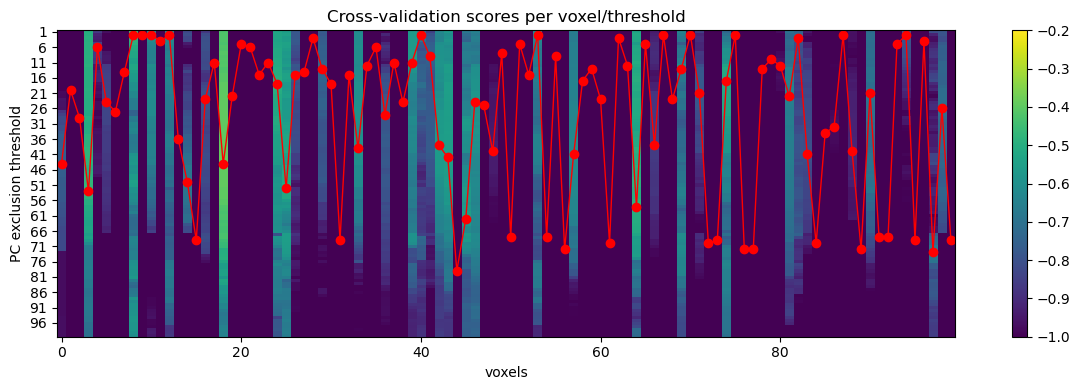

In [16]:
if opt['cv_mode'] > -1:

    # Create a figure to visualize cross-validation scores per voxel/threshold
    plt.figure(figsize=(12, 4))

    # Plot the mean cross-validation scores for each threshold
    plt.imshow(results['cv_scores'].mean(1), aspect='auto', interpolation='none', clim=(-1, -0.2))

    # Set y-axis ticks to display thresholds every 5 steps
    plt.yticks(np.arange(len(opt['cv_thresholds']))[::5], np.array(opt['cv_thresholds'])[::5])

    # Add a red dashed line to indicate the optimal threshold
    if opt['cv_threshold_per'] == 'population':
        # For population-based thresholding
        plt.plot([-0.5, nvox + 0.5], [results['best_threshold'].mean(), results['best_threshold'].mean()], 'r--', linewidth=2)
    elif opt['cv_threshold_per'] == 'unit':
        # For unit-based thresholding
        plt.plot(np.arange(nvox), results['best_threshold'], 'ro-', linewidth=1)

    # Set plot limits for x-axis
    plt.xlim([-0.5, nvox - 0.5])

    # Add colorbar for the heatmap
    plt.colorbar()

    # Add axis labels and title
    plt.xlabel('voxels')
    plt.ylabel('PC exclusion threshold')
    plt.title('Cross-validation scores per voxel/threshold')

    plt.tight_layout()
    plt.show()

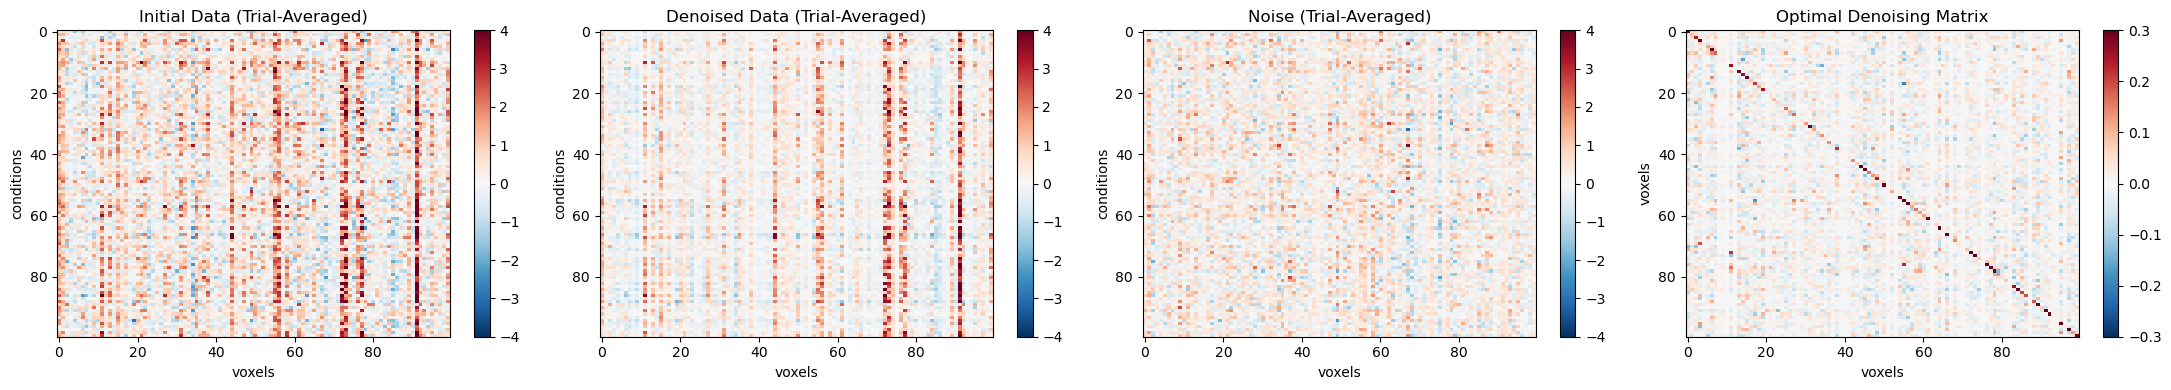

In [17]:
# Create a figure to compare the initial data, denoised data, noise, and denoising matrix
plt.figure(figsize=(22, 4))

# Plot trial-averaged initial data
plt.subplot(141)
plt.imshow(test_avg.T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.title('Initial Data (Trial-Averaged)')
plt.xlabel('voxels')
plt.ylabel('conditions')

# Plot trial-averaged denoised data
plt.subplot(142)
plt.imshow(test_denoised_avg.T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.title('Denoised Data (Trial-Averaged)')
plt.xlabel('voxels')
plt.ylabel('conditions')

# Plot trial-averaged noise
plt.subplot(143)
plt.imshow(noise.T, aspect='auto', interpolation='none', clim=(-4, 4), cmap='RdBu_r')
plt.colorbar()
plt.xlabel('voxels')
plt.ylabel('conditions')
plt.title('Noise (Trial-Averaged)')

# Plot the optimal denoising matrix
plt.subplot(144)
plt.imshow(results['denoiser'], aspect='auto', interpolation='none', clim=(-0.3, 0.3), cmap='RdBu_r')
plt.colorbar()
plt.xlabel('voxels')
plt.ylabel('voxels')
plt.title('Optimal Denoising Matrix')

plt.tight_layout()
plt.show()

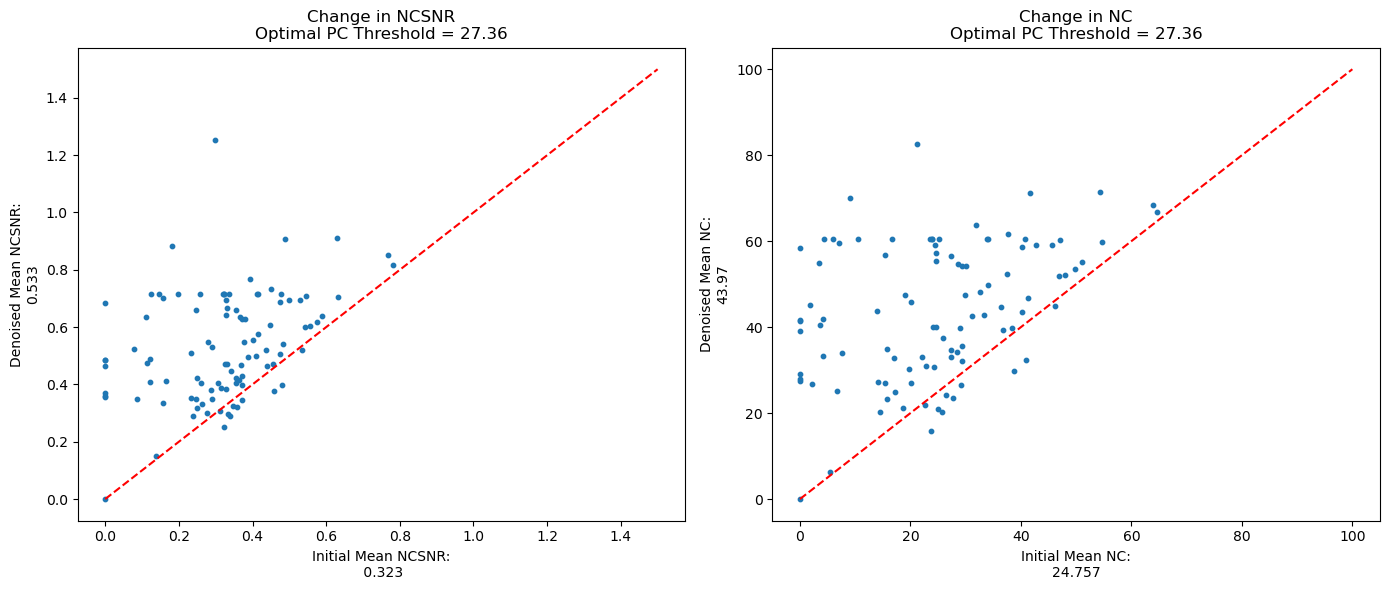

In [19]:
# Reshape data to match expected dimensions (voxels, conditions, trials)
test_data_reshaped = test_data.transpose(0, 1, 2)  # Should be (nvox, nconds, ntrials)
test_data_denoised_reshaped = test_data_denoised.transpose(0, 1, 2)  # Should be (nvox, nconds, ntrials)

# Calculate metrics for initial and denoised data
initial_nc, initial_ncsnr, initial_sigvar, initial_noisevar = compute_noise_ceiling(test_data_reshaped)
denoised_nc, denoised_ncsnr, denoised_sigvar, denoised_noisevar = compute_noise_ceiling(test_data_denoised_reshaped)

# Create a figure to visualize changes in NCSNR and NC after denoising
plt.figure(figsize=(14, 6))

# Scatter plot of initial vs. denoised NCSNR
plt.subplot(121)
plt.scatter(initial_ncsnr, denoised_ncsnr, 10)  # Scatter points
plt.xlabel(f'Initial Mean NCSNR:\n {round(np.mean(initial_ncsnr), 3)}')  # X-axis label
plt.ylabel(f'Denoised Mean NCSNR:\n{round(np.mean(denoised_ncsnr), 3)}')  # Y-axis label
plt.plot([0, 1.5], [0, 1.5], 'r--')  # Red dashed line for reference

# Add a title indicating the optimal PC threshold
if opt['cv_threshold_per'] == 'population':
    plt.title(f'Change in NCSNR\nOptimal PC Threshold = {results["best_threshold"]}')
else:
    plt.title(f'Change in NCSNR\nOptimal PC Threshold = {results["best_threshold"].mean()}')

# Scatter plot of initial vs. denoised NC
plt.subplot(122)
plt.scatter(initial_nc, denoised_nc, 10)  # Scatter points
plt.xlabel(f'Initial Mean NC:\n{round(np.mean(initial_nc), 3)}')  # X-axis label
plt.ylabel(f'Denoised Mean NC:\n{round(np.mean(denoised_nc), 3)}')  # Y-axis label
plt.plot([0, 100], [0, 100], 'r--')  # Red dashed line for reference

# Add a title indicating the optimal PC threshold
if opt['cv_threshold_per'] == 'population':
    plt.title(f'Change in NC\nOptimal PC Threshold = {results["best_threshold"]}')
else:
    plt.title(f'Change in NC\nOptimal PC Threshold = {results["best_threshold"].mean()}')

plt.tight_layout()
plt.show()

In [20]:
# Compute the Pearson correlation between pairwise distances in the data and noise
stats.pearsonr(
    pdist(test_data.mean(2).T, 'correlation'),  # Pairwise distances of the trial-averaged test data
    pdist(noise.T, 'correlation')      # Pairwise distances of the trial-averaged noise
)




PearsonRResult(statistic=np.float64(0.6461459174775509), pvalue=np.float64(0.0))